In [24]:
import os
import sys
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [25]:
root = "./stanford-dogs-dataset/images/Images/"
thumbroot = "./thumbnails/"

In [26]:
## Helper Functions

def writeProgress(msg, count, total):
    sys.stdout.write(msg + "{:.2%}\r".format(count/total))
    sys.stdout.flush()
    
def getAnnotations(ann_path):
    tree = ET.parse(ann_path)
    root = tree.getroot()
    xmin = int(root.find("object/bndbox/xmin").text)
    ymin = int(root.find("object/bndbox/ymin").text)
    xmax = int(root.find("object/bndbox/xmax").text)
    ymax = int(root.find("object/bndbox/ymax").text)
    return (xmin, ymin, xmax, ymax)

def getAnnpath(img_path):
    ann_path = img_path.replace("images", "annotations").replace("Images", "Annotation")
    ann_path = os.path.splitext(ann_path)[0]
    return ann_path

In [27]:
## Generate Label Dictionary (id, label)

dictionary={}
subdirs = os.listdir(root)
for dir in subdirs:
    key = dir.split("-", 1)[0]
    value = dir.split("-", 1)[1]
    dictionary[key] = value

In [28]:
## Data Size
print("Calculating data size ...")

count = 0
heights = []
widths = []
for path, subdirs, files in os.walk(root):
    for name in files:
        img_path = os.path.join(path, name)
        img = Image.open(img_path)
        w, h = img.size
        widths.append(w)
        heights.append(h)
        
        count += 1
        sys.stdout.write("Progress calculating: {:.2%}\r".format(count/20580))
        sys.stdout.flush()

min_height = min(heights)
min_width = min(widths)
total = count

Calculating data size ...


In [29]:
print("Number of image: ", total)
print("Min image height: ", min_height)
print("Min image width: ", min_width)

Number of image:  20580
Min image height:  100
Min image width:  97


In [35]:
## Generate same-sized, grey-scaled images in another file
print("Generating same-sized, grey-scaled images ...")

# Check if old files exists
files = os.listdir(thumbroot)
if files:
    for f in files:
        os.unlink(os.path.join(thumbroot, f))
    
# Start generating 
count = 0
for path, subdirs, files in os.walk(root):
    for name in files:
        img_path = os.path.join(path, name)
        thumb_path = os.path.join(thumbroot, name)
        ann_path = getAnnpath(img_path)
        
        img = Image.open(img_path)
        cr_img = img.crop(getAnnotations(ann_path))
        re_img = cr_img.resize((100, 100), Image.ANTIALIAS)
        gr_img = re_img.convert("L")
        gr_img.save(thumb_path, quality=95)

        count += 1
        writeProgress("Progress generating images: ", count, total)

Generating same-sized, grey-scaled images ...


In [36]:
## Read Images to ndarray
print("Reading images ...")

images = []
labels = []
count = 0

for name in os.listdir(thumbroot):
    img_path = os.path.join(thumbroot, name)
    img = mpimg.imread(img_path)
    images.append(img)

    key = name.split("_", 1)[0]
    label = dictionary[key]
    labels.append(label)

    count += 1
    writeProgress("Progress loading images: ", count, total)

X = np.array(images)
Y = np.array(labels)

Reading images ...


In [37]:
## Data Size (after resizing)
print("X shape: ", X.shape)
print("Y size: ", Y.size)

X shape:  (20580, 100, 100)
Y size:  20580


(100, 100)


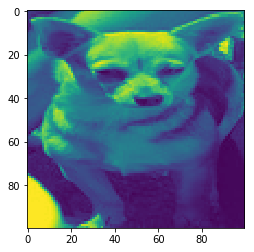

In [38]:
plt.imshow(X[0])
print(X[0].shape)

In [39]:
## Flaten Image List (bcuz NMF only consumes 2D data)

X_flat = np.array(X).reshape((X.shape[0], X.shape[1]*X.shape[2]))

In [40]:
## Split Test / Train
print("Spliting Test / Train sets ...")

X_train, X_test, y_train, y_test = train_test_split(X_flat, Y, test_size=0.3, random_state=42)

Spliting Test / Train sets ...


In [41]:
## Data Size (after spliting)
print("X train shape: ", X_train.shape)
print("Y train size: ", y_train.size)
print("X test shape: ", X_test.shape)
print("Y test size: ", y_test.size)

X train shape:  (14406, 10000)
Y train size:  14406
X test shape:  (6174, 10000)
Y test size:  6174


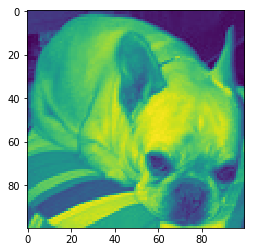

In [42]:
plt.imshow(X_train[0].reshape(X.shape[1], X.shape[2]))

In [43]:
## PCA
print("PCA ...")

pca = PCA(n_components=1000)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

PCA ...


In [44]:
## Data Size
print("Reduced Shape: " + str(X_reduced.shape))
print("Recovered Shape: " + str(X_recovered.shape))

Reduced Shape: (14406, 1000)
Recovered Shape: (14406, 10000)


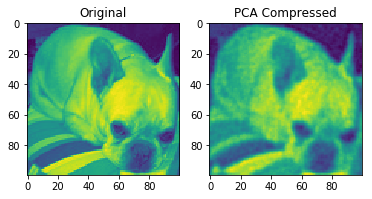

In [45]:
f = plt.figure()
f.add_subplot(1, 2, 1)
plt.title("Original")
plt.imshow(X_train[0].reshape(X.shape[1], X.shape[2]))

f.add_subplot(1,2, 2)
plt.title("PCA Compressed")
plt.imshow(X_recovered[0].reshape(X.shape[1], X.shape[2]))

plt.show(block=True)

In [46]:
## Classification - MLP (reduced)
print("Classifying reduced images ...")

# Training
print("Training ...")

mlp_reduced = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(20, 20, 20), random_state=1, verbose=True)
mlp_reduced.fit(X_reduced, y_train)

# Testing
print("Testing ...")

X_test_reduced = pca.transform(X_test)
y_hat_reduced = mlp_reduced.predict(X_test_reduced)

Classifying reduced images ...
Training ...
Iteration 1, loss = 17.28893015
Iteration 2, loss = 7.85621351
Iteration 3, loss = 5.66600358
Iteration 4, loss = 5.07716564
Iteration 5, loss = 4.84082484
Iteration 6, loss = 4.70872195
Iteration 7, loss = 4.65772300
Iteration 8, loss = 4.58074259
Iteration 9, loss = 4.53044359
Iteration 10, loss = 4.49358670
Iteration 11, loss = 4.45292238
Iteration 12, loss = 4.42184583
Iteration 13, loss = 4.41127876
Iteration 14, loss = 4.37521785
Iteration 15, loss = 4.39745427
Iteration 16, loss = 4.38163607
Iteration 17, loss = 4.34214066
Iteration 18, loss = 4.29661473
Iteration 19, loss = 4.25654223
Iteration 20, loss = 4.32117291
Iteration 21, loss = 4.27160701
Iteration 22, loss = 4.25091427
Iteration 23, loss = 4.18665920
Iteration 24, loss = 4.18390602
Iteration 25, loss = 4.16860310
Iteration 26, loss = 4.14135354
Iteration 27, loss = 4.10895859
Iteration 28, loss = 4.07878235
Iteration 29, loss = 4.08898578
Iteration 30, loss = 4.24356615
Iter

In [47]:
## Evaluations of reduced images
print("accuracy: " + str(accuracy_score(y_test, y_hat_reduced)))

accuracy: 0.016196954972465177


In [48]:
## Classification - MLP (original)
print("Classifying original images ...")

# Training
print("Training ...")

mlp_orgn = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(20, 20, 20), random_state=1, verbose=True)
mlp_orgn.fit(X_train, y_train)

Classifying original images ...
Training ...
Iteration 1, loss = 6.32249687
Iteration 2, loss = 4.79009486
Iteration 3, loss = 4.78745495
Iteration 4, loss = 4.78534716
Iteration 5, loss = 4.78356136
Iteration 6, loss = 4.78221776
Iteration 7, loss = 4.78125996
Iteration 8, loss = 4.78045411
Iteration 9, loss = 4.77975707
Iteration 10, loss = 4.77932306
Iteration 11, loss = 4.77895034
Iteration 12, loss = 4.77870300
Iteration 13, loss = 4.77841817
Iteration 14, loss = 4.77832446
Iteration 15, loss = 4.77821211
Iteration 16, loss = 4.77809906
Iteration 17, loss = 4.77799480
Iteration 18, loss = 4.77795989
Iteration 19, loss = 4.77791231
Iteration 20, loss = 4.77784863
Iteration 21, loss = 4.77787207
Iteration 22, loss = 4.77780675
Iteration 23, loss = 4.77781842
Iteration 24, loss = 4.77778796
Iteration 25, loss = 4.77775891
Iteration 26, loss = 4.77775923
Iteration 27, loss = 4.77772926
Iteration 28, loss = 4.77771620
Training loss did not improve more than tol=0.000100 for 10 consecut

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 20, 20), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False)

In [49]:
# Testing
print("Testing ...")

y_hat_orgn = mlp_orgn.predict(X_test)

Testing ...


In [50]:
## Evaluations of original images
print("accuracy: " + str(accuracy_score(y_test, y_hat_orgn)))

accuracy: 0.009556203433754453
